In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
import copy
import pandas as pd
import tqdm
from pathlib import Path
import scipy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1650'

# Custom NN

In [64]:
class CUSTOM(nn.Module):
    def __init__(self, num_classes=40, channels=9, samples=250, subbands=5):
        super(CUSTOM, self).__init__()
        # [batch, subbands, channels, time]
        # Subband combination layer
        self.subband_combination = nn.Conv2d(
            subbands, 1, kernel_size=(1, 1), bias=False
        )
        self.time_filter = nn.Conv2d(
            1,
            120,
            kernel_size=(1, samples // 2),
            padding="same",
        )
        self.relu1 = nn.ReLU()
        # First dropout
        self.drop1 = nn.Dropout(0.1)
        self.channel_combination = nn.Conv2d(120, 120, kernel_size=(channels, 1))
        # Second droput
        self.drop2 = nn.Dropout(0.1)
        self.relu2 = nn.ReLU()
        # 4th conv - FIR filtering
        self.fourth_conv = nn.Conv2d(120, 120, kernel_size=(1, 2), stride=(1, 2))
        self.fir = nn.Conv2d(120, 40, kernel_size=(1, 10), padding="same")
        self.drop3 = nn.Dropout(0.9)

        # Fully connected layer - Classifier
        self.fc = nn.Linear(40 * (samples // 2), num_classes)

        self._initialize_weights()

    def _initialize_weights(self):
        with torch.no_grad():
            self.subband_combination.weight.fill_(1.0)

    def forward(self, x):
        # x shape: [batch, subbands, channels, time]
        x = self.subband_combination(x)  # [batch, 1, channels, time]
        x = self.time_filter(x)  # [batch, 120, 1, time/2]
        x = self.relu1(x)
        x = self.drop1(x)
        x = self.channel_combination(x)  # [batch, 120, 1, time/2]
        x = self.drop2(x)
        x = self.relu2(x)
        x = self.fourth_conv(x)  # [batch, 120, 1, time/2]
        x = self.fir(x)  # [batch, 40, 1, time/2]
        x = self.drop3(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc(x)  # [batch, num_classes]
        # output = F.softmax(x, dim=1)
        return x

# Utility Functions, Preprocessing and training loop

In [36]:
from cross_subject_utils import (
    plot_learning_curves,
    evaluate,
    load_data_from_users,
    filter_signals_subbands,
)

In [37]:
def train(
    model,
    train_loader,
    val_loader,
    criterion,
    optimizer,
    num_epochs=100,
    device=0,
    save_path="best_model.pth",
):
    best_val_accuracy = -float("inf")
    model.to(device)
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    for epoch in tqdm.notebook.tqdm(range(num_epochs)):
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            train_correct += (preds == labels).sum().item()
            train_total += labels.size(0)
        train_accuracy = train_correct / train_total
        avg_train_loss = running_loss / len(train_loader)
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.inference_mode():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)
        val_accuracy = val_correct / val_total
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_accuracy)
        val_accuracies.append(val_accuracy)
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model = copy.deepcopy(model.state_dict())
            torch.save(model.state_dict(), save_path)
        print(
            f"Epoch {epoch + 1}/{num_epochs}: "
            f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
            f"Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}"
        )
    plot_learning_curves(train_losses, val_losses, train_accuracies, val_accuracies)
    model.load_state_dict(best_model)
    return model

## Leave One User Out

In [ ]:
frequencias_e_fases = scipy.io.loadmat(
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
frequencias = frequencias_e_fases["freqs"]
frequencias = np.round(frequencias, 2).ravel()
fases = frequencias_e_fases["phases"]

# Parâmetros de pré-processamento
sample_rate = 250
delay = 160  # 160 amostras, 0,5s (sem estimulação) + 0,14s (latencia para começo da evocação)

# Parâmetros de janelas e sessões
tamanho_da_janela_seg = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela_seg * sample_rate))

# Eletrodos e frequências de interesse
occipital_electrodes = np.array(
    [47, 53, 54, 55, 56, 57, 60, 61, 62]
)  # O1, O2, Oz, PO3, PO4, POz, PO7, PO8, Pz
frequencias_desejadas = frequencias[:8]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

# Usuários
# users = list(range(1, 36))  # Usuários de 1 a 35
users = list(range(1, 11))  # Usuários de 1 a 10

epochs = 250
exp_dir = Path(
    f"custom/3_{len(users)}_users_{len(frequencias_desejadas)}_freqs_{tamanho_da_janela_seg}_s/"
)

In [14]:
print("Usuários de interesse:", users)
print("Frequências de interesse:", frequencias_desejadas)
print("Indices das frequências de interesse:", indices)

Usuários de interesse: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Frequências de interesse: [ 8.  9. 10. 11. 12. 13. 14. 15.]
Indices das frequências de interesse: [0, 1, 2, 3, 4, 5, 6, 7]


In [15]:
all_data = load_data_from_users(users=users, visual_delay=delay, filter_bandpass=False)

Carregando dados dos usuários:   0%|          | 0/10 [00:00<?, ?it/s]

Processando Usuário 1
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 3.1120, Train Accuracy: 0.1199, Val Loss: 2.1949, Val Accuracy: 0.0923
Epoch 2/250: Train Loss: 2.7029, Train Accuracy: 0.1144, Val Loss: 2.1736, Val Accuracy: 0.1846
Epoch 3/250: Train Loss: 2.5789, Train Accuracy: 0.1499, Val Loss: 2.1396, Val Accuracy: 0.2308
Epoch 4/250: Train Loss: 2.4031, Train Accuracy: 0.1362, Val Loss: 2.1133, Val Accuracy: 0.2615
Epoch 5/250: Train Loss: 2.3523, Train Accuracy: 0.1635, Val Loss: 2.0975, Val Accuracy: 0.2154
Epoch 6/250: Train Loss: 2.2973, Train Accuracy: 0.1744, Val Loss: 2.0999, Val Accuracy: 0.2308
Epoch 7/250: Train Loss: 2.2758, Train Accuracy: 0.1635, Val Loss: 2.1019, Val Accuracy: 0.2462
Epoch 8/250: Train Loss: 2.1400, Train Accuracy: 0.1989, Val Loss: 2.0993, Val Accuracy: 0.2615
Epoch 9/250: Train Loss: 2.0385, Train Accuracy: 0.2316, Val Loss: 2.0930, Val Accuracy: 0.2308
Epoch 10/250: Train Loss: 2.0713, Train Accuracy: 0.2234, Val Loss: 2.0812, Val Accuracy: 0.2615
Epoch 11/250: Train Loss: 1.9544, Train

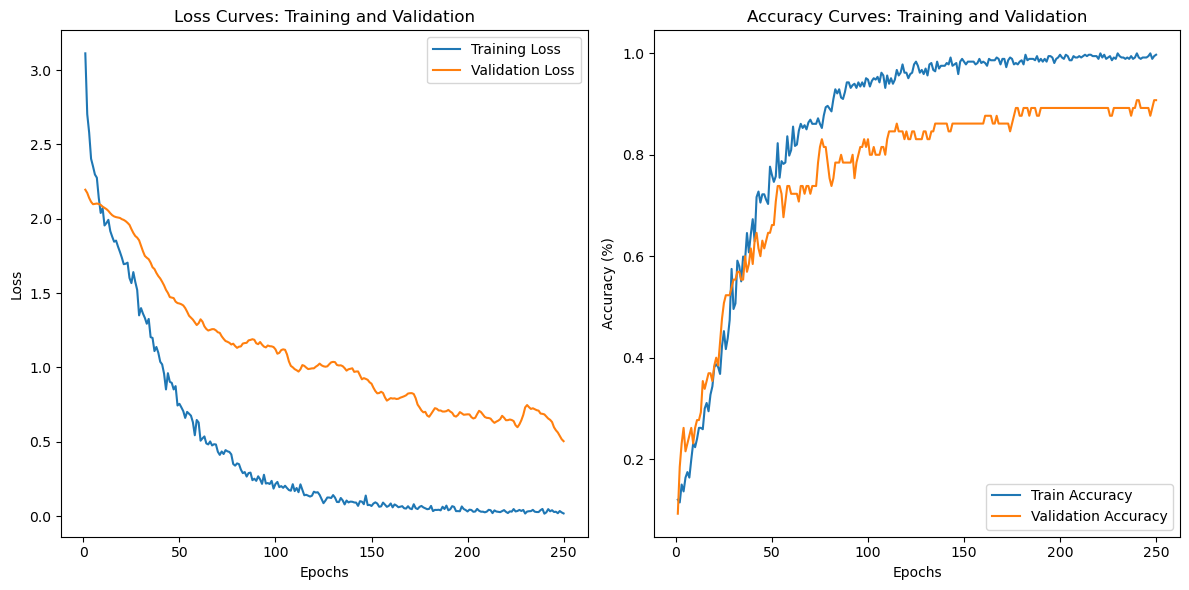

Test set Accuracy: 0.7292
Recall: 0.7292
F1 Score: 0.7114


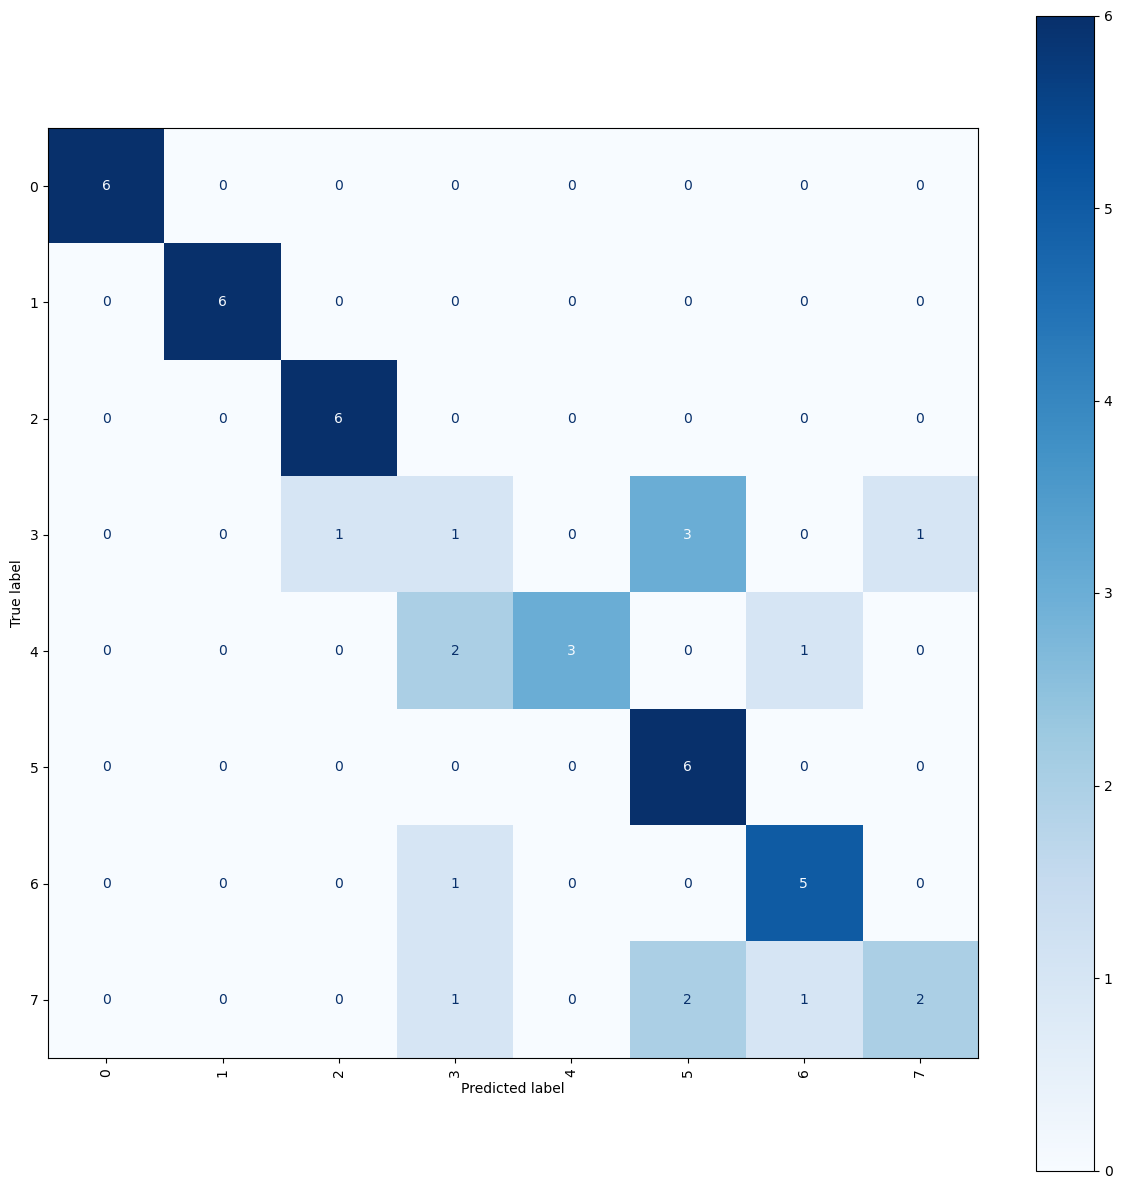

Usuário 1 Finalizado: Acurácia=0.7292, Recall=0.7292, F1=0.7114
--------------------------------------------------
Processando Usuário 2
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.8190, Train Accuracy: 0.1499, Val Loss: 2.1047, Val Accuracy: 0.1846
Epoch 2/250: Train Loss: 2.6615, Train Accuracy: 0.1172, Val Loss: 2.0712, Val Accuracy: 0.2000
Epoch 3/250: Train Loss: 2.5019, Train Accuracy: 0.1362, Val Loss: 2.0563, Val Accuracy: 0.2615
Epoch 4/250: Train Loss: 2.3655, Train Accuracy: 0.1390, Val Loss: 2.0467, Val Accuracy: 0.2000
Epoch 5/250: Train Loss: 2.2493, Train Accuracy: 0.1907, Val Loss: 2.0352, Val Accuracy: 0.2462
Epoch 6/250: Train Loss: 2.2059, Train Accuracy: 0.1744, Val Loss: 2.0341, Val Accuracy: 0.2308
Epoch 7/250: Train Loss: 2.1559, Train Accuracy: 0.1989, Val Loss: 2.0313, Val Accuracy: 0.2154
Epoch 8/250: Train Loss: 2.1394, Train Accuracy: 0.1989, Val Loss: 2.0257, Val Accuracy: 0.2615
Epoch 9/250: Train Loss: 2.0396, Train Accuracy: 0.2016, Val Loss: 2.0151, Val Accuracy: 0.2923
Epoch 10/250: Train Loss: 1.9922, Train Accuracy: 0.2262, Val Loss: 2.0056, Val Accuracy: 0.3077
Epoch 11/250: Train Loss: 1.9237, Train

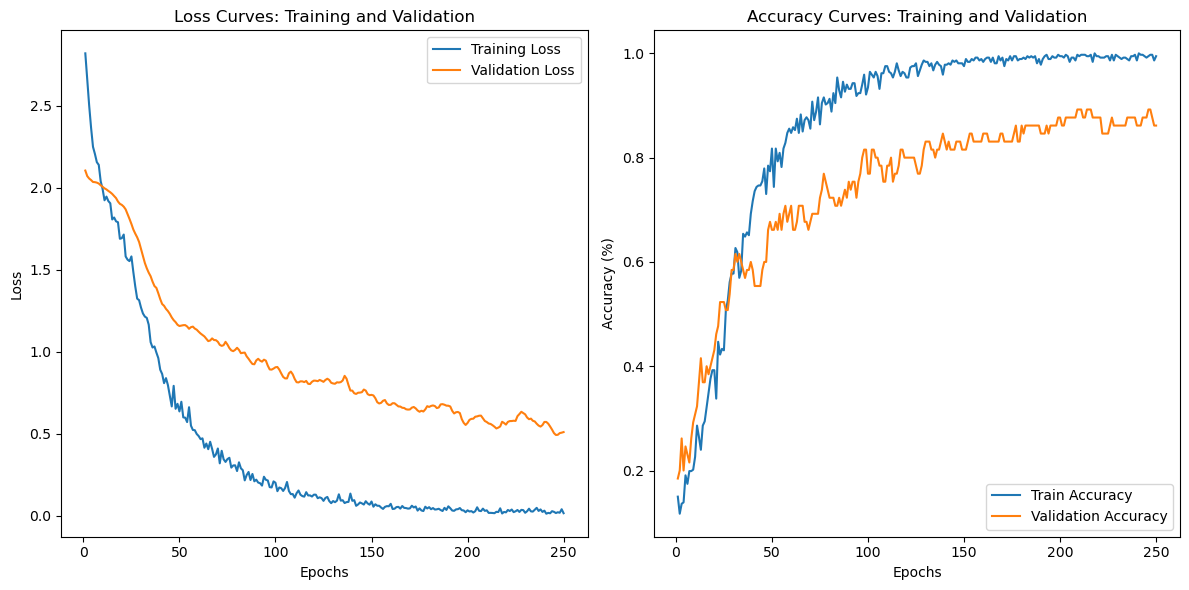

Test set Accuracy: 0.6250
Recall: 0.6250
F1 Score: 0.6085


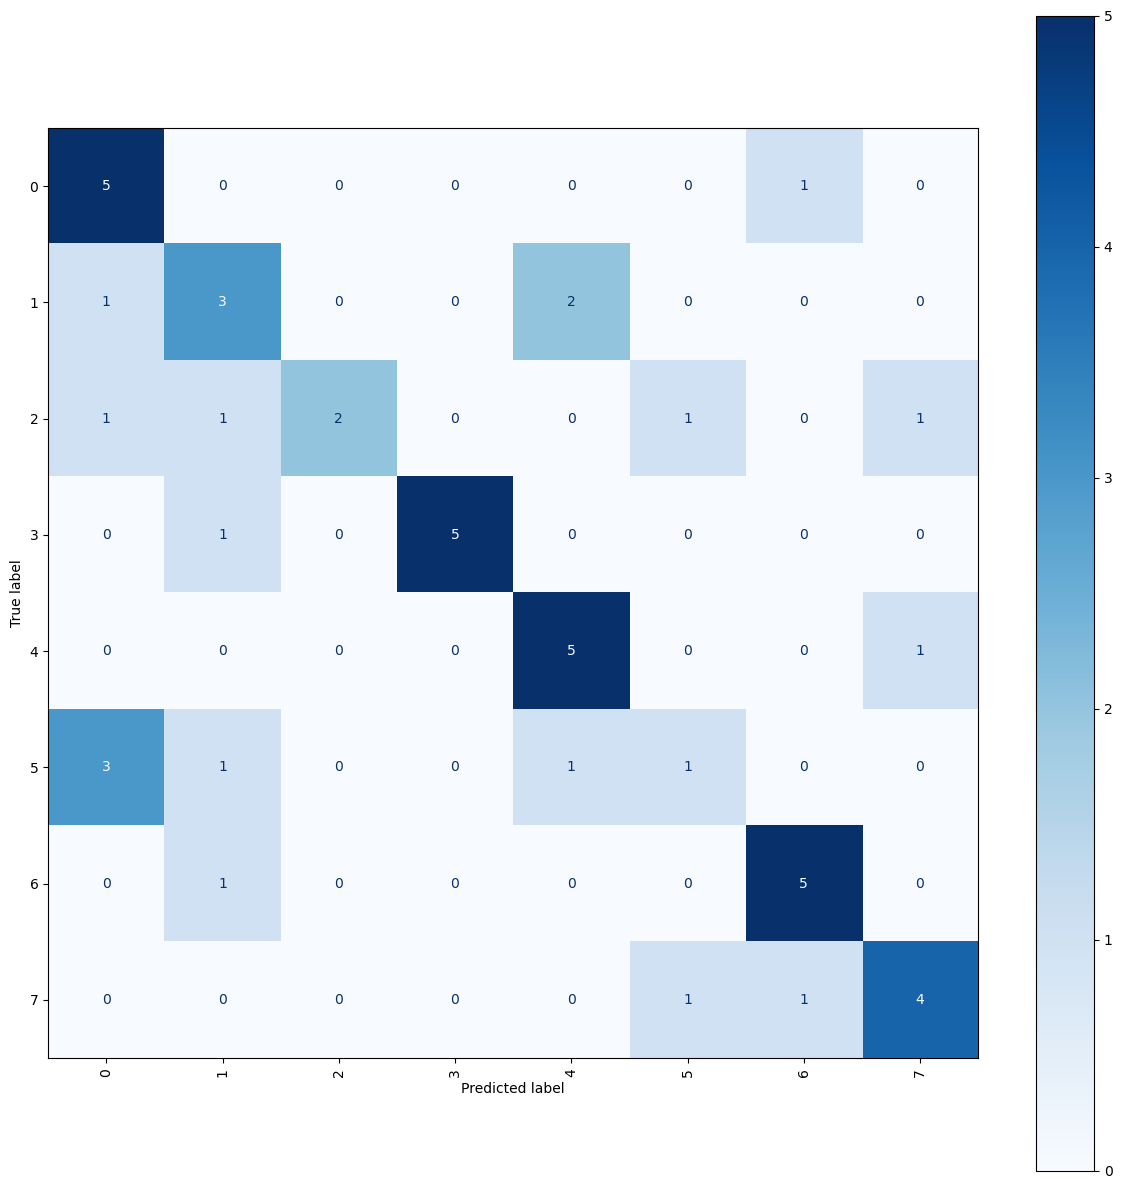

Usuário 2 Finalizado: Acurácia=0.6250, Recall=0.6250, F1=0.6085
--------------------------------------------------
Processando Usuário 3
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.9223, Train Accuracy: 0.1199, Val Loss: 2.0361, Val Accuracy: 0.2000
Epoch 2/250: Train Loss: 2.6079, Train Accuracy: 0.1417, Val Loss: 2.0421, Val Accuracy: 0.1692
Epoch 3/250: Train Loss: 2.4929, Train Accuracy: 0.1335, Val Loss: 2.0453, Val Accuracy: 0.1538
Epoch 4/250: Train Loss: 2.4424, Train Accuracy: 0.1471, Val Loss: 2.0316, Val Accuracy: 0.2000
Epoch 5/250: Train Loss: 2.2184, Train Accuracy: 0.1771, Val Loss: 2.0164, Val Accuracy: 0.2462
Epoch 6/250: Train Loss: 2.2476, Train Accuracy: 0.1880, Val Loss: 2.0125, Val Accuracy: 0.2615
Epoch 7/250: Train Loss: 2.1725, Train Accuracy: 0.1662, Val Loss: 2.0070, Val Accuracy: 0.2769
Epoch 8/250: Train Loss: 2.1281, Train Accuracy: 0.2071, Val Loss: 2.0037, Val Accuracy: 0.2462
Epoch 9/250: Train Loss: 2.1221, Train Accuracy: 0.2262, Val Loss: 2.0051, Val Accuracy: 0.2308
Epoch 10/250: Train Loss: 1.9546, Train Accuracy: 0.2534, Val Loss: 2.0105, Val Accuracy: 0.2308
Epoch 11/250: Train Loss: 2.0033, Train

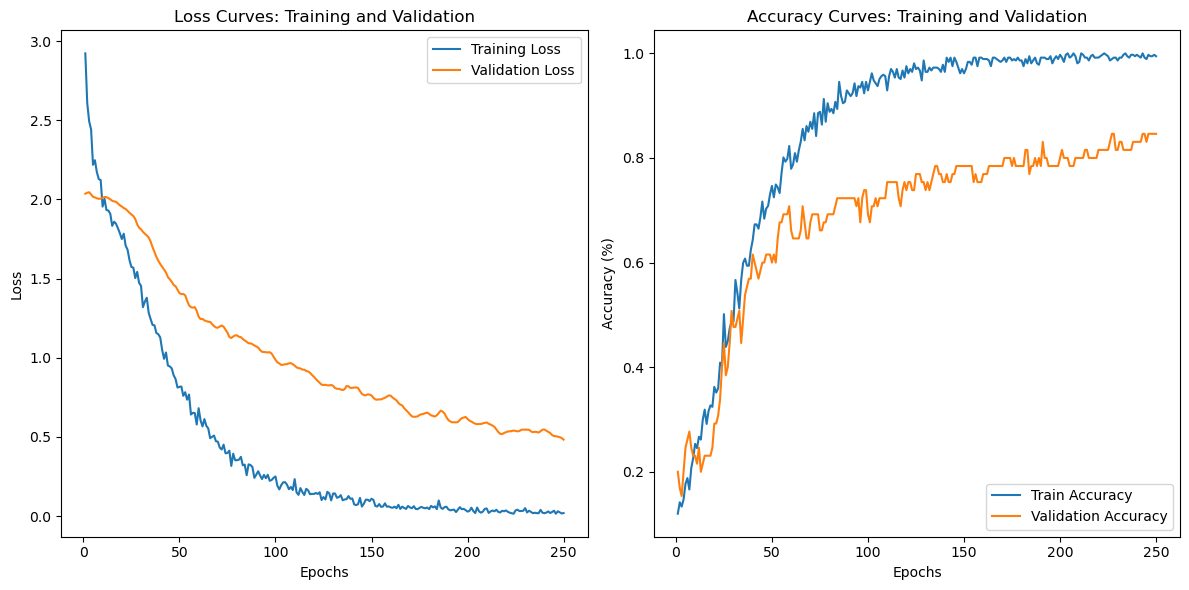

Test set Accuracy: 0.9583
Recall: 0.9583
F1 Score: 0.9582


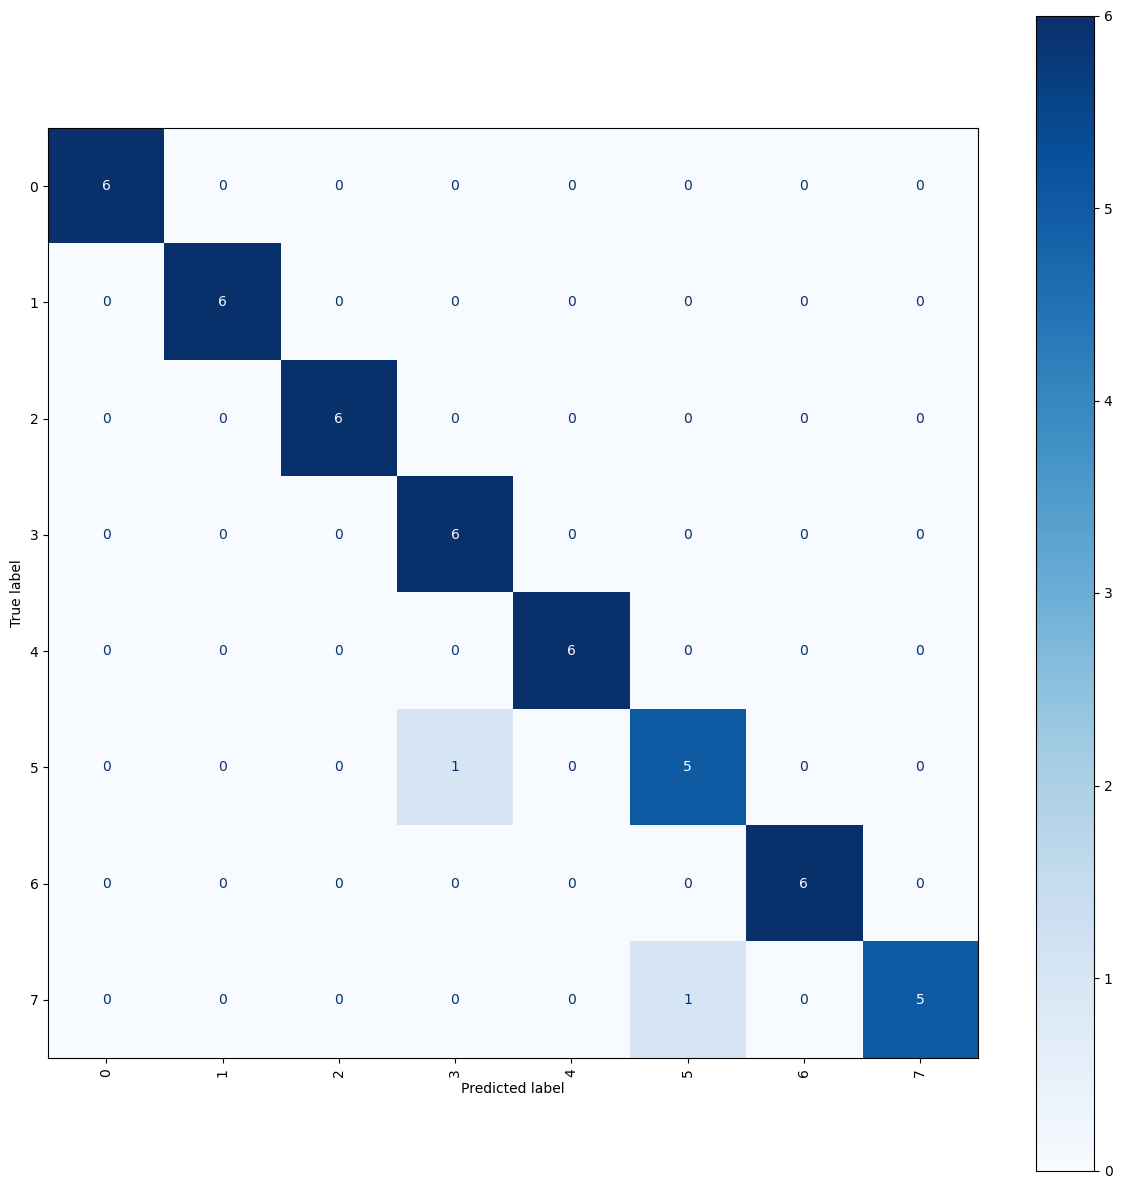

Usuário 3 Finalizado: Acurácia=0.9583, Recall=0.9583, F1=0.9582
--------------------------------------------------
Processando Usuário 4
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.6796, Train Accuracy: 0.1226, Val Loss: 2.0692, Val Accuracy: 0.1692
Epoch 2/250: Train Loss: 2.6472, Train Accuracy: 0.1199, Val Loss: 2.0577, Val Accuracy: 0.1231
Epoch 3/250: Train Loss: 2.3232, Train Accuracy: 0.1826, Val Loss: 2.0451, Val Accuracy: 0.1692
Epoch 4/250: Train Loss: 2.2254, Train Accuracy: 0.1880, Val Loss: 2.0368, Val Accuracy: 0.1385
Epoch 5/250: Train Loss: 2.2258, Train Accuracy: 0.1798, Val Loss: 2.0328, Val Accuracy: 0.2154
Epoch 6/250: Train Loss: 2.2260, Train Accuracy: 0.1717, Val Loss: 2.0267, Val Accuracy: 0.2308
Epoch 7/250: Train Loss: 2.1796, Train Accuracy: 0.1853, Val Loss: 2.0189, Val Accuracy: 0.2615
Epoch 8/250: Train Loss: 2.0788, Train Accuracy: 0.2125, Val Loss: 2.0126, Val Accuracy: 0.2615
Epoch 9/250: Train Loss: 1.9734, Train Accuracy: 0.2207, Val Loss: 2.0051, Val Accuracy: 0.2615
Epoch 10/250: Train Loss: 1.9146, Train Accuracy: 0.2861, Val Loss: 2.0016, Val Accuracy: 0.2462
Epoch 11/250: Train Loss: 1.9050, Train

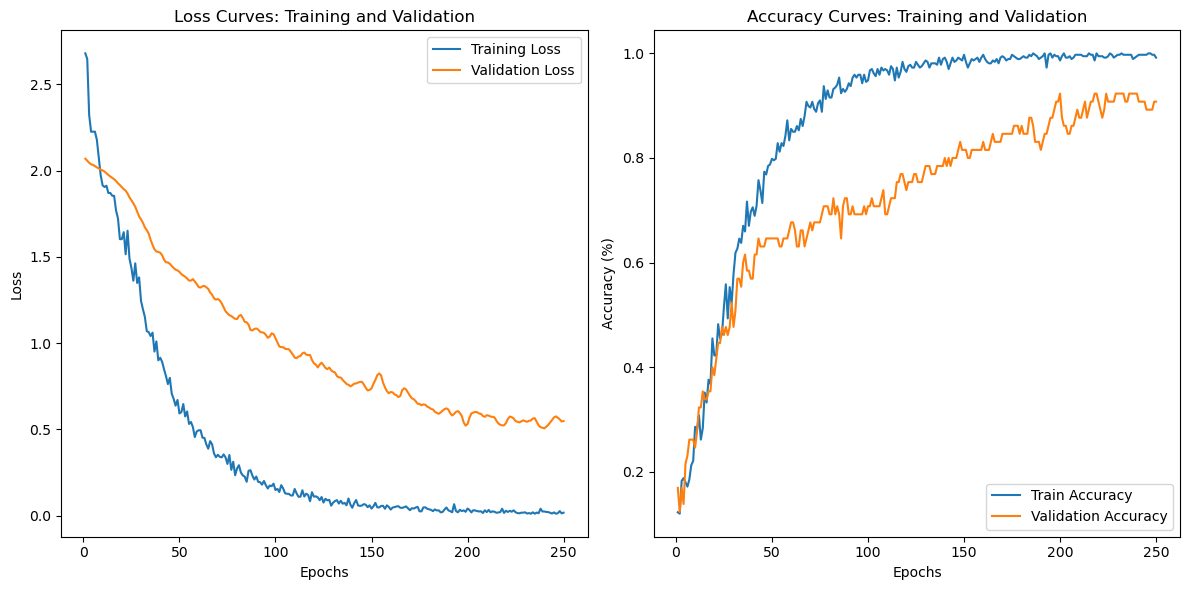

Test set Accuracy: 0.4167
Recall: 0.4167
F1 Score: 0.3976


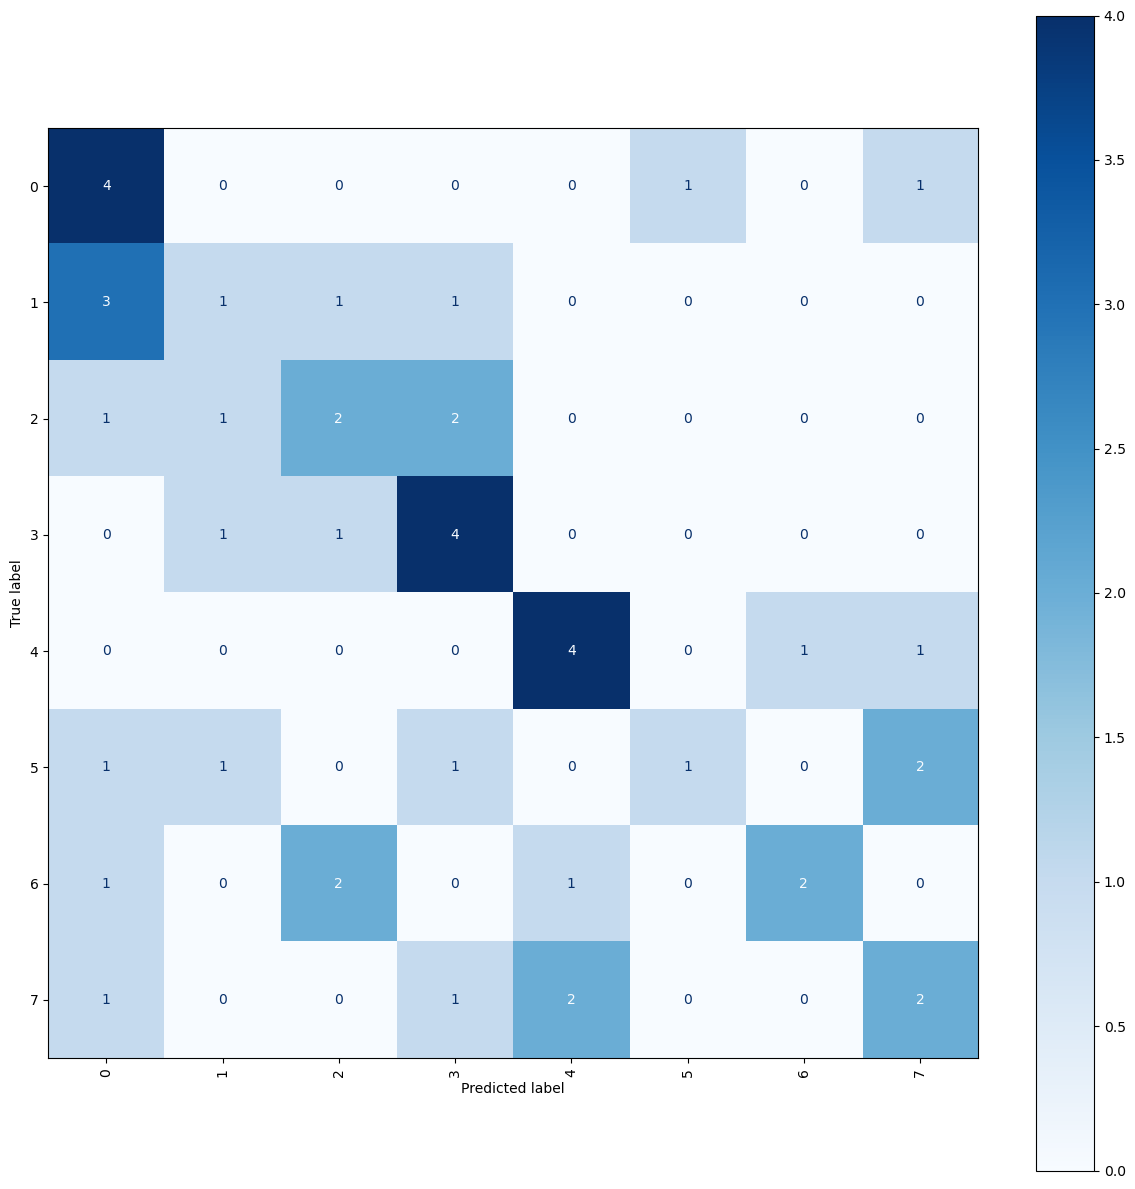

Usuário 4 Finalizado: Acurácia=0.4167, Recall=0.4167, F1=0.3976
--------------------------------------------------
Processando Usuário 5
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.9338, Train Accuracy: 0.1063, Val Loss: 2.1308, Val Accuracy: 0.1846
Epoch 2/250: Train Loss: 2.6520, Train Accuracy: 0.1417, Val Loss: 2.1141, Val Accuracy: 0.1077
Epoch 3/250: Train Loss: 2.5306, Train Accuracy: 0.1281, Val Loss: 2.0929, Val Accuracy: 0.2154
Epoch 4/250: Train Loss: 2.3903, Train Accuracy: 0.1608, Val Loss: 2.0828, Val Accuracy: 0.2154
Epoch 5/250: Train Loss: 2.2347, Train Accuracy: 0.1744, Val Loss: 2.0731, Val Accuracy: 0.2462
Epoch 6/250: Train Loss: 2.1633, Train Accuracy: 0.1907, Val Loss: 2.0669, Val Accuracy: 0.2923
Epoch 7/250: Train Loss: 2.0924, Train Accuracy: 0.2153, Val Loss: 2.0589, Val Accuracy: 0.2923
Epoch 8/250: Train Loss: 2.1271, Train Accuracy: 0.1717, Val Loss: 2.0517, Val Accuracy: 0.2769
Epoch 9/250: Train Loss: 2.0785, Train Accuracy: 0.1962, Val Loss: 2.0457, Val Accuracy: 0.2615
Epoch 10/250: Train Loss: 1.9774, Train Accuracy: 0.2507, Val Loss: 2.0396, Val Accuracy: 0.3077
Epoch 11/250: Train Loss: 1.9772, Train

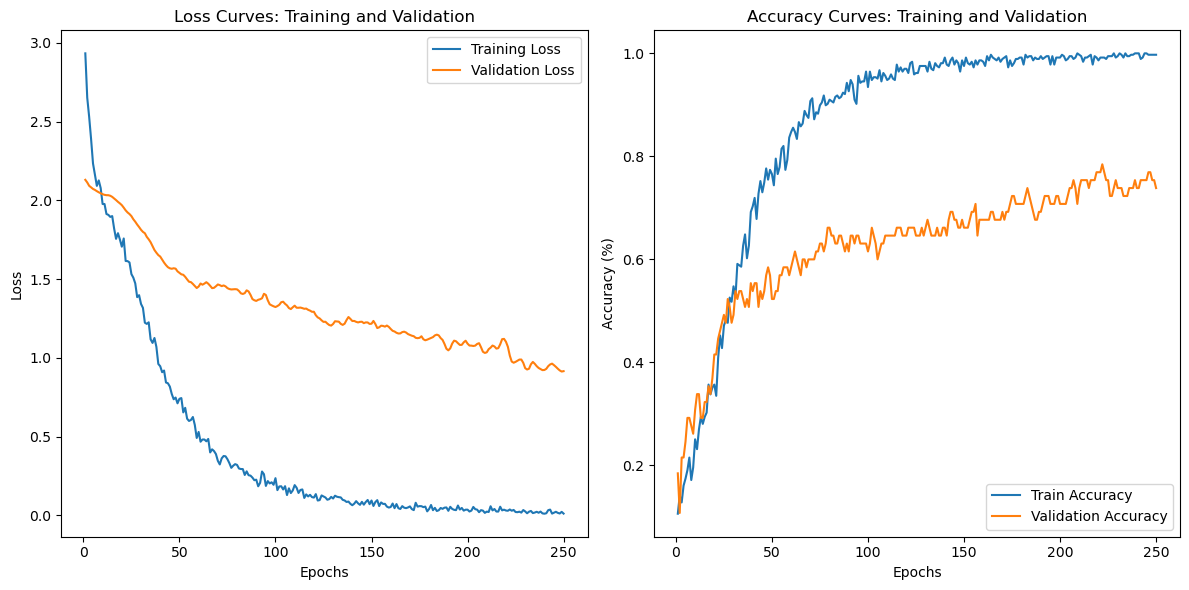

Test set Accuracy: 0.7917
Recall: 0.7917
F1 Score: 0.7899


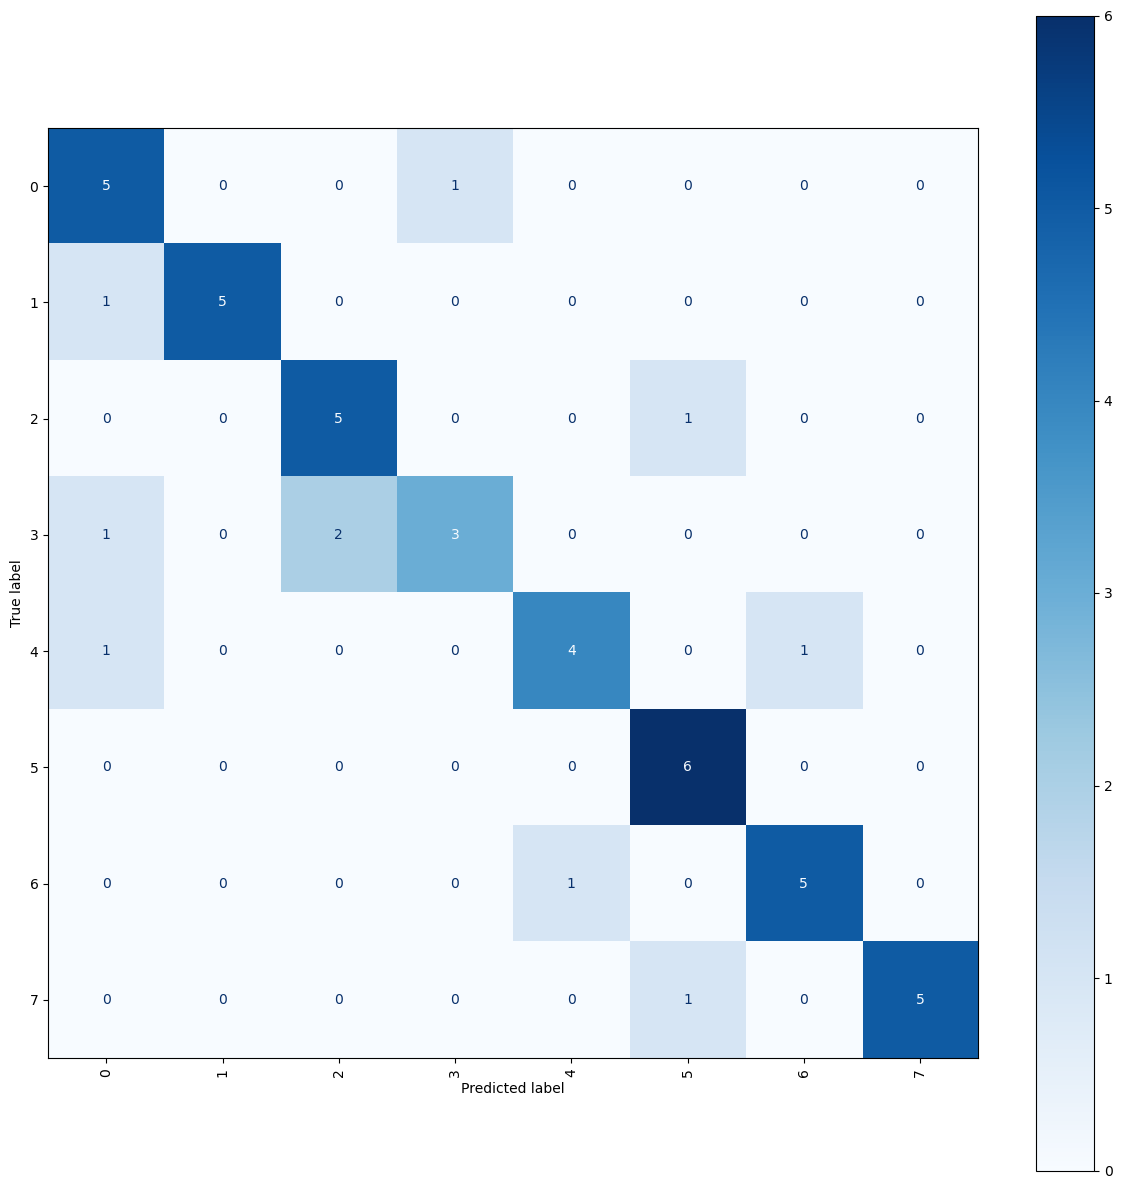

Usuário 5 Finalizado: Acurácia=0.7917, Recall=0.7917, F1=0.7899
--------------------------------------------------
Processando Usuário 6
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 3.1604, Train Accuracy: 0.1253, Val Loss: 2.1241, Val Accuracy: 0.1231
Epoch 2/250: Train Loss: 2.6809, Train Accuracy: 0.0981, Val Loss: 2.1067, Val Accuracy: 0.1077
Epoch 3/250: Train Loss: 2.4305, Train Accuracy: 0.1417, Val Loss: 2.0926, Val Accuracy: 0.1077
Epoch 4/250: Train Loss: 2.3155, Train Accuracy: 0.1880, Val Loss: 2.0779, Val Accuracy: 0.1538
Epoch 5/250: Train Loss: 2.2958, Train Accuracy: 0.1771, Val Loss: 2.0623, Val Accuracy: 0.1385
Epoch 6/250: Train Loss: 2.2117, Train Accuracy: 0.1880, Val Loss: 2.0520, Val Accuracy: 0.1385
Epoch 7/250: Train Loss: 2.1559, Train Accuracy: 0.1744, Val Loss: 2.0469, Val Accuracy: 0.1385
Epoch 8/250: Train Loss: 2.0879, Train Accuracy: 0.2071, Val Loss: 2.0385, Val Accuracy: 0.2000
Epoch 9/250: Train Loss: 2.0138, Train Accuracy: 0.2262, Val Loss: 2.0316, Val Accuracy: 0.2154
Epoch 10/250: Train Loss: 2.0256, Train Accuracy: 0.2125, Val Loss: 2.0242, Val Accuracy: 0.2615
Epoch 11/250: Train Loss: 1.9830, Train

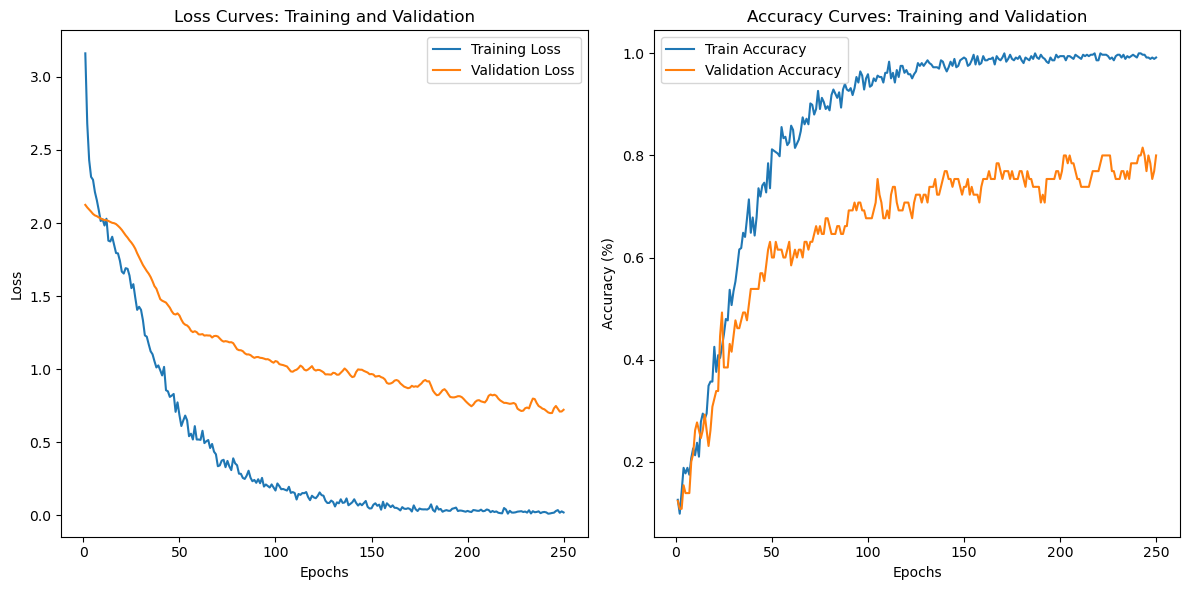

Test set Accuracy: 0.8333
Recall: 0.8333
F1 Score: 0.8235


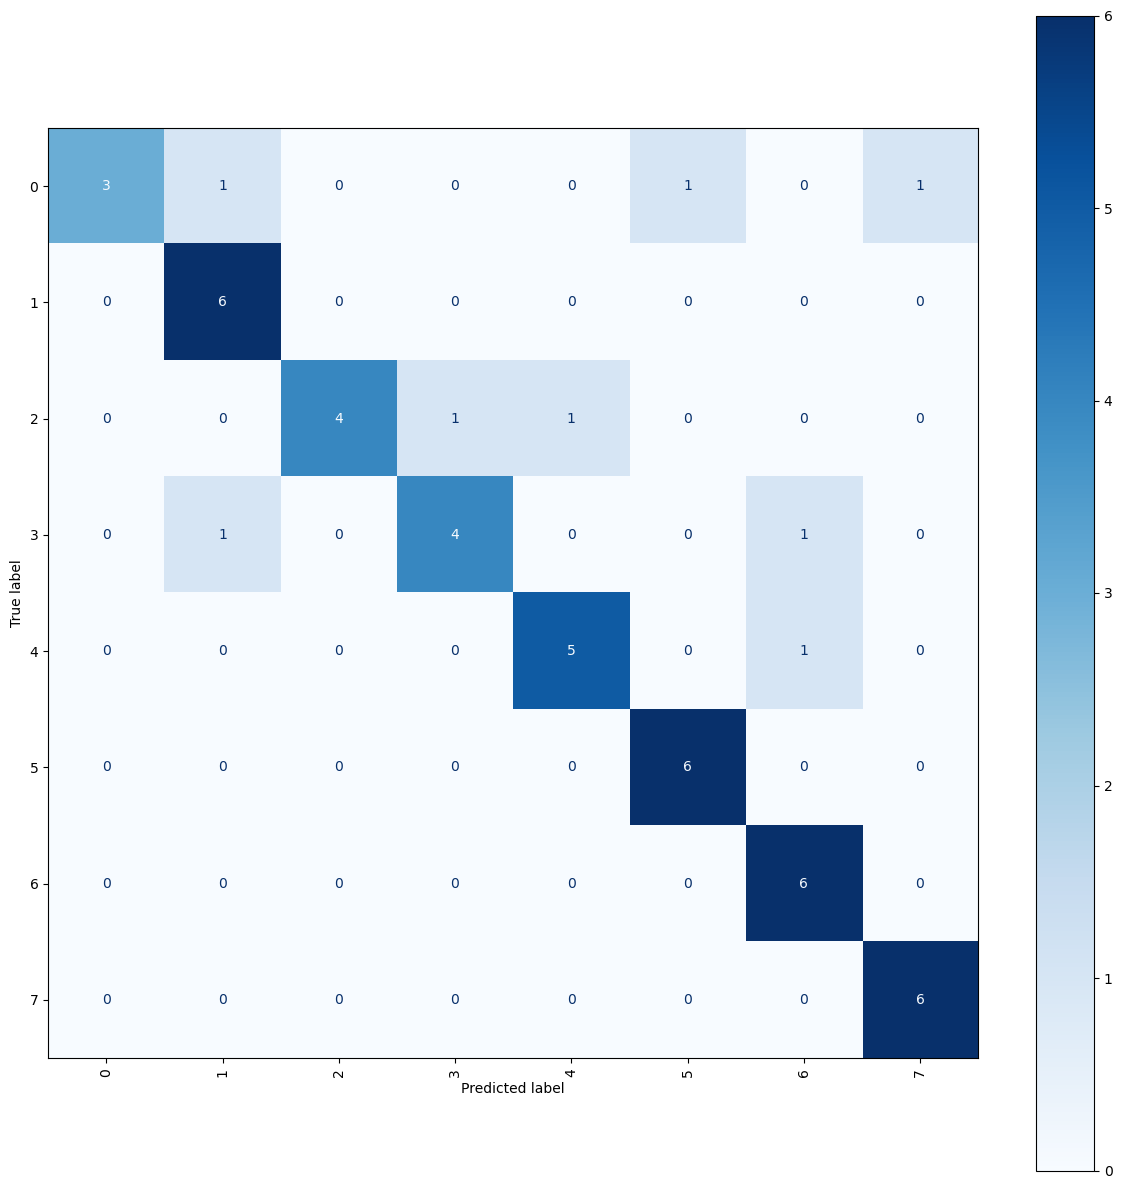

Usuário 6 Finalizado: Acurácia=0.8333, Recall=0.8333, F1=0.8235
--------------------------------------------------
Processando Usuário 7
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 3.0092, Train Accuracy: 0.1090, Val Loss: 2.1179, Val Accuracy: 0.1846
Epoch 2/250: Train Loss: 2.4628, Train Accuracy: 0.1580, Val Loss: 2.1233, Val Accuracy: 0.2154
Epoch 3/250: Train Loss: 2.4434, Train Accuracy: 0.1553, Val Loss: 2.1166, Val Accuracy: 0.2154
Epoch 4/250: Train Loss: 2.3554, Train Accuracy: 0.1499, Val Loss: 2.1063, Val Accuracy: 0.2615
Epoch 5/250: Train Loss: 2.2483, Train Accuracy: 0.1580, Val Loss: 2.0934, Val Accuracy: 0.2462
Epoch 6/250: Train Loss: 2.1305, Train Accuracy: 0.1826, Val Loss: 2.0876, Val Accuracy: 0.2615
Epoch 7/250: Train Loss: 2.0241, Train Accuracy: 0.2452, Val Loss: 2.0805, Val Accuracy: 0.2462
Epoch 8/250: Train Loss: 2.1093, Train Accuracy: 0.1989, Val Loss: 2.0697, Val Accuracy: 0.2769
Epoch 9/250: Train Loss: 2.0338, Train Accuracy: 0.2316, Val Loss: 2.0654, Val Accuracy: 0.2769
Epoch 10/250: Train Loss: 2.0190, Train Accuracy: 0.2589, Val Loss: 2.0571, Val Accuracy: 0.2769
Epoch 11/250: Train Loss: 1.9251, Train

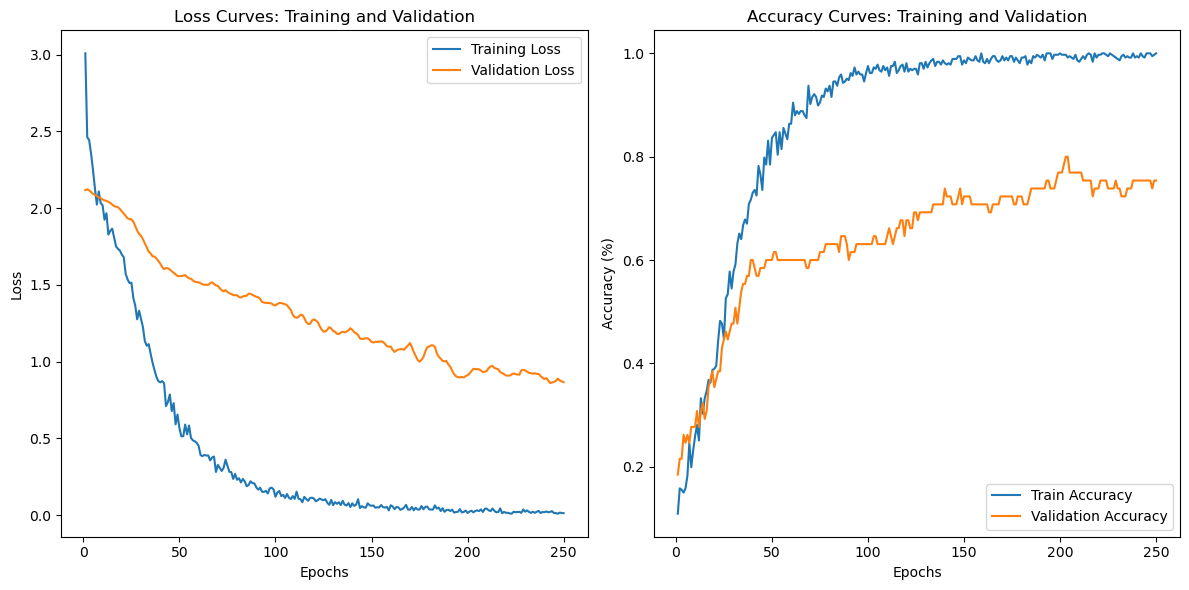

Test set Accuracy: 0.6250
Recall: 0.6250
F1 Score: 0.6232


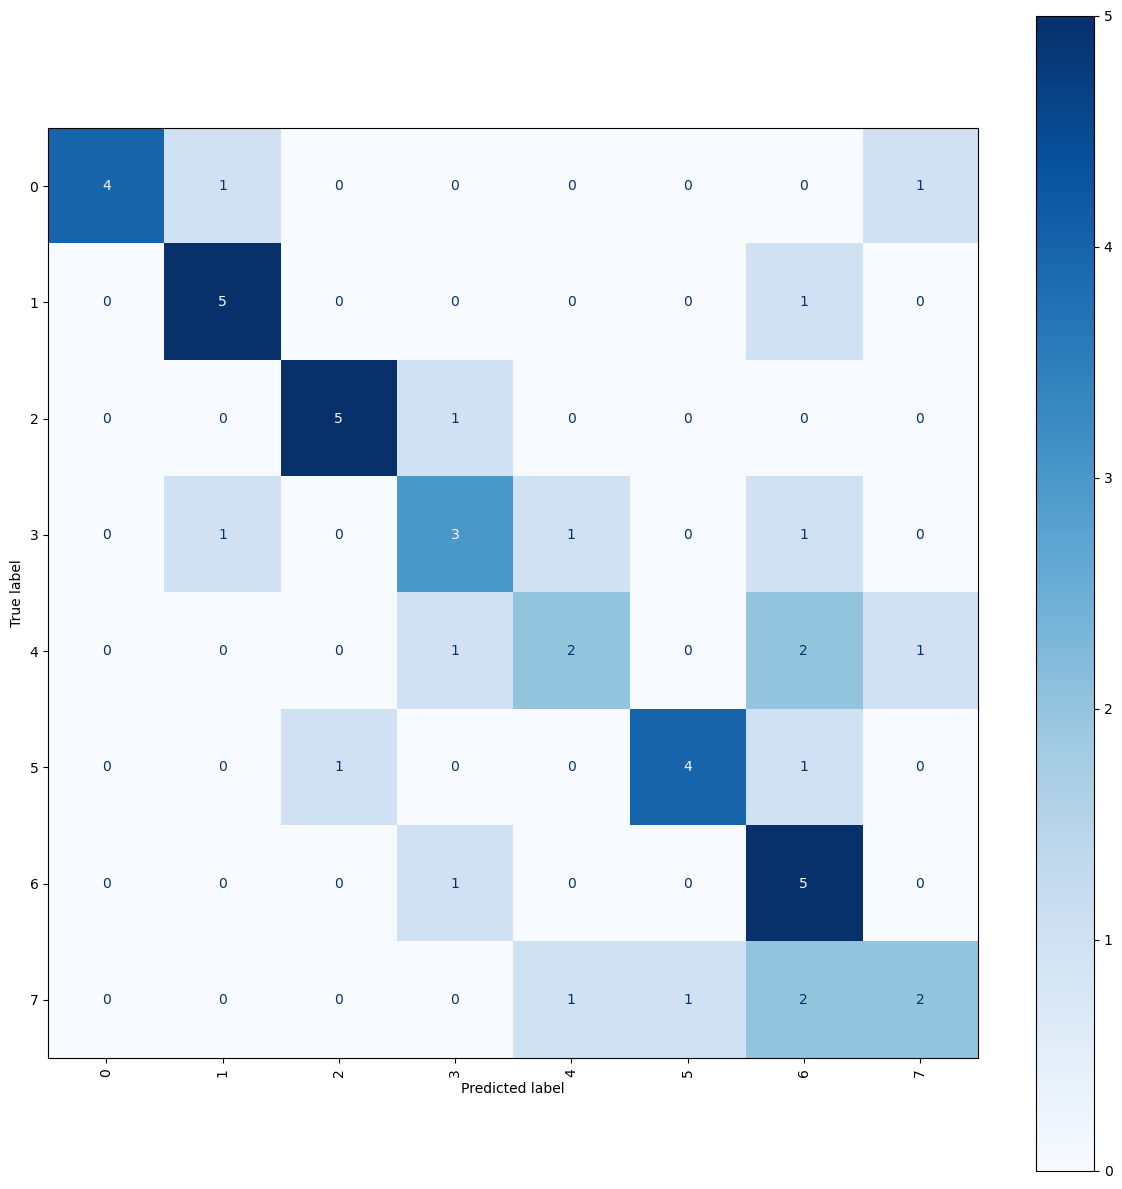

Usuário 7 Finalizado: Acurácia=0.6250, Recall=0.6250, F1=0.6232
--------------------------------------------------
Processando Usuário 8
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.8861, Train Accuracy: 0.1444, Val Loss: 2.0055, Val Accuracy: 0.2154
Epoch 2/250: Train Loss: 2.5795, Train Accuracy: 0.1444, Val Loss: 1.9706, Val Accuracy: 0.1538
Epoch 3/250: Train Loss: 2.5952, Train Accuracy: 0.1253, Val Loss: 1.9588, Val Accuracy: 0.2462
Epoch 4/250: Train Loss: 2.3758, Train Accuracy: 0.1308, Val Loss: 1.9630, Val Accuracy: 0.2769
Epoch 5/250: Train Loss: 2.2620, Train Accuracy: 0.1689, Val Loss: 1.9632, Val Accuracy: 0.2769
Epoch 6/250: Train Loss: 2.2163, Train Accuracy: 0.1798, Val Loss: 1.9645, Val Accuracy: 0.3077
Epoch 7/250: Train Loss: 2.1707, Train Accuracy: 0.1962, Val Loss: 1.9655, Val Accuracy: 0.2923
Epoch 8/250: Train Loss: 2.1118, Train Accuracy: 0.2098, Val Loss: 1.9597, Val Accuracy: 0.2923
Epoch 9/250: Train Loss: 2.0730, Train Accuracy: 0.2234, Val Loss: 1.9524, Val Accuracy: 0.3231
Epoch 10/250: Train Loss: 1.9364, Train Accuracy: 0.2480, Val Loss: 1.9487, Val Accuracy: 0.3231
Epoch 11/250: Train Loss: 1.9656, Train

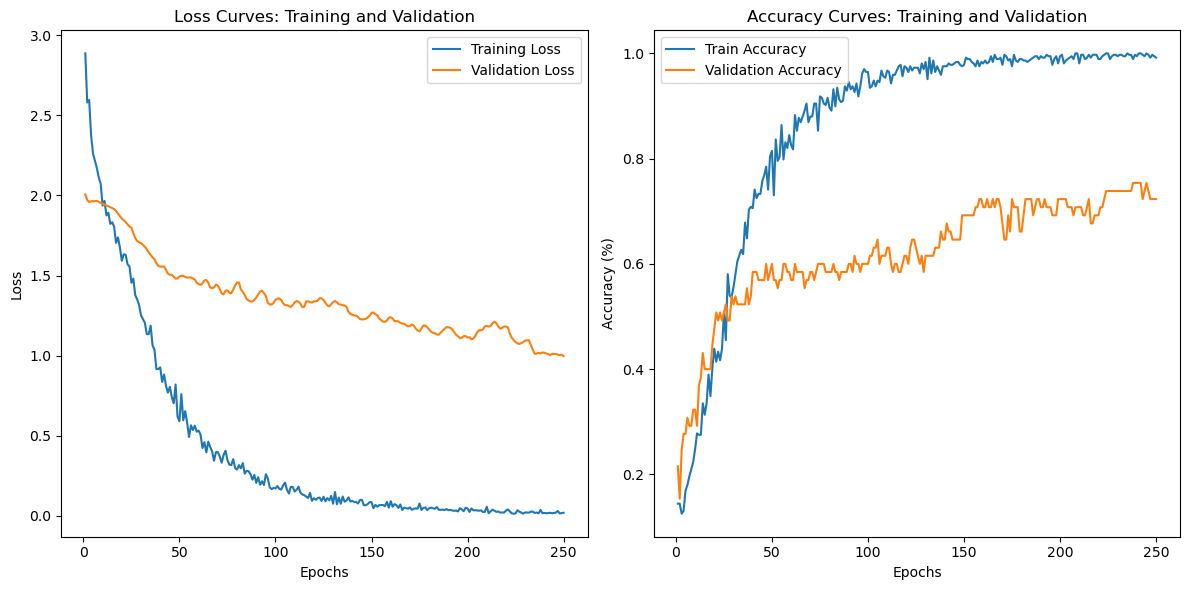

Test set Accuracy: 0.7708
Recall: 0.7708
F1 Score: 0.7746


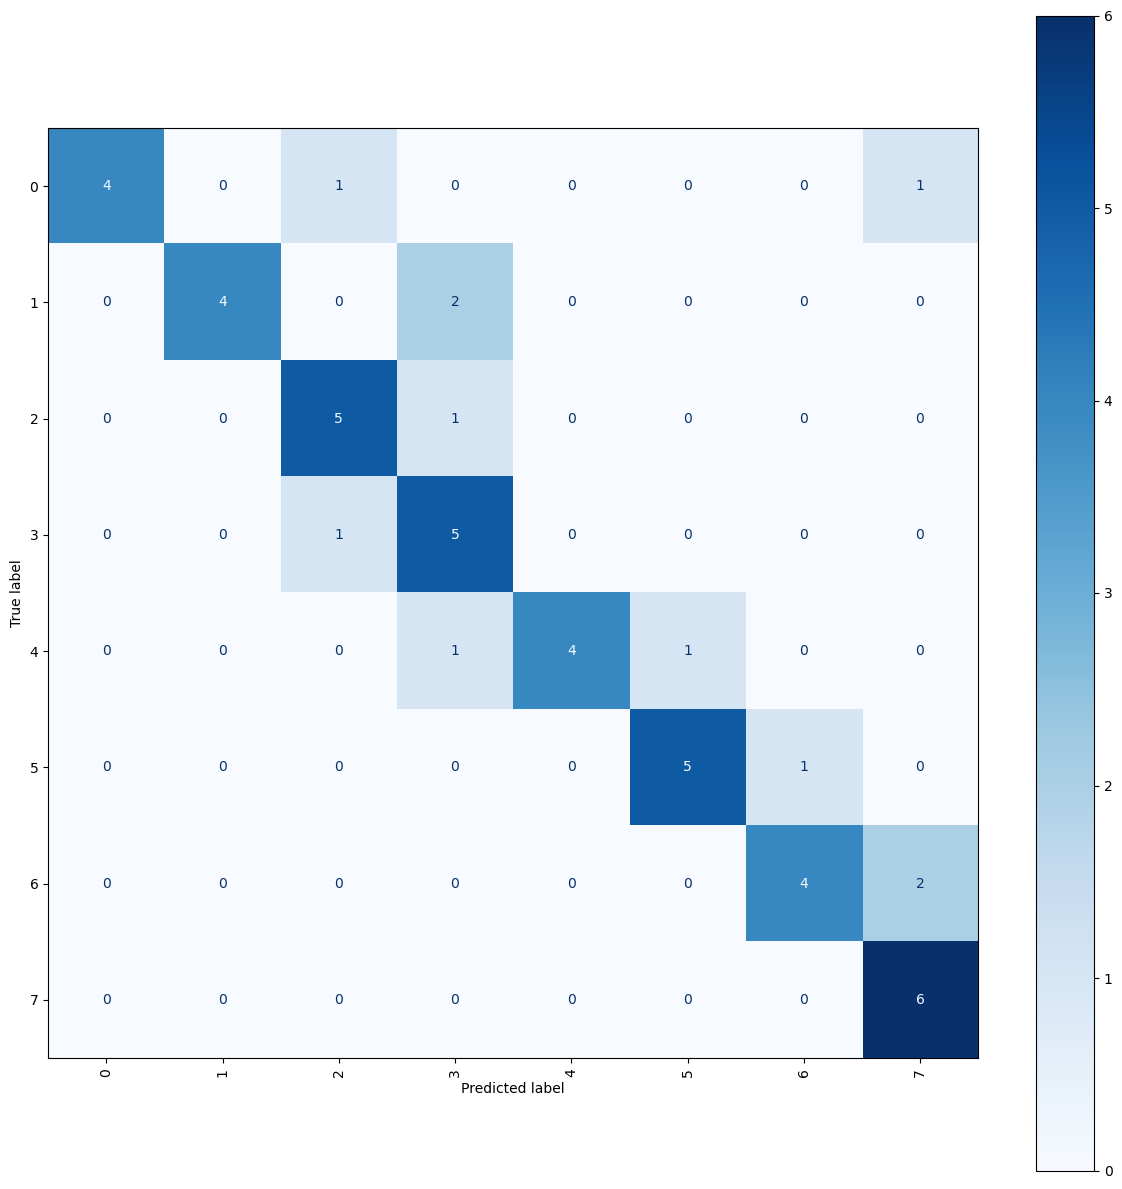

Usuário 8 Finalizado: Acurácia=0.7708, Recall=0.7708, F1=0.7746
--------------------------------------------------
Processando Usuário 9
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 2.8095, Train Accuracy: 0.1226, Val Loss: 2.1918, Val Accuracy: 0.0615
Epoch 2/250: Train Loss: 2.5188, Train Accuracy: 0.1226, Val Loss: 2.1574, Val Accuracy: 0.1077
Epoch 3/250: Train Loss: 2.3617, Train Accuracy: 0.1281, Val Loss: 2.1235, Val Accuracy: 0.1077
Epoch 4/250: Train Loss: 2.2967, Train Accuracy: 0.1226, Val Loss: 2.1070, Val Accuracy: 0.0769
Epoch 5/250: Train Loss: 2.2401, Train Accuracy: 0.1662, Val Loss: 2.0983, Val Accuracy: 0.1077
Epoch 6/250: Train Loss: 2.0889, Train Accuracy: 0.1907, Val Loss: 2.0905, Val Accuracy: 0.1077
Epoch 7/250: Train Loss: 2.0372, Train Accuracy: 0.2398, Val Loss: 2.0816, Val Accuracy: 0.0923
Epoch 8/250: Train Loss: 2.0114, Train Accuracy: 0.2316, Val Loss: 2.0707, Val Accuracy: 0.1385
Epoch 9/250: Train Loss: 2.0286, Train Accuracy: 0.2316, Val Loss: 2.0633, Val Accuracy: 0.1692
Epoch 10/250: Train Loss: 1.9582, Train Accuracy: 0.2425, Val Loss: 2.0554, Val Accuracy: 0.1692
Epoch 11/250: Train Loss: 1.9444, Train

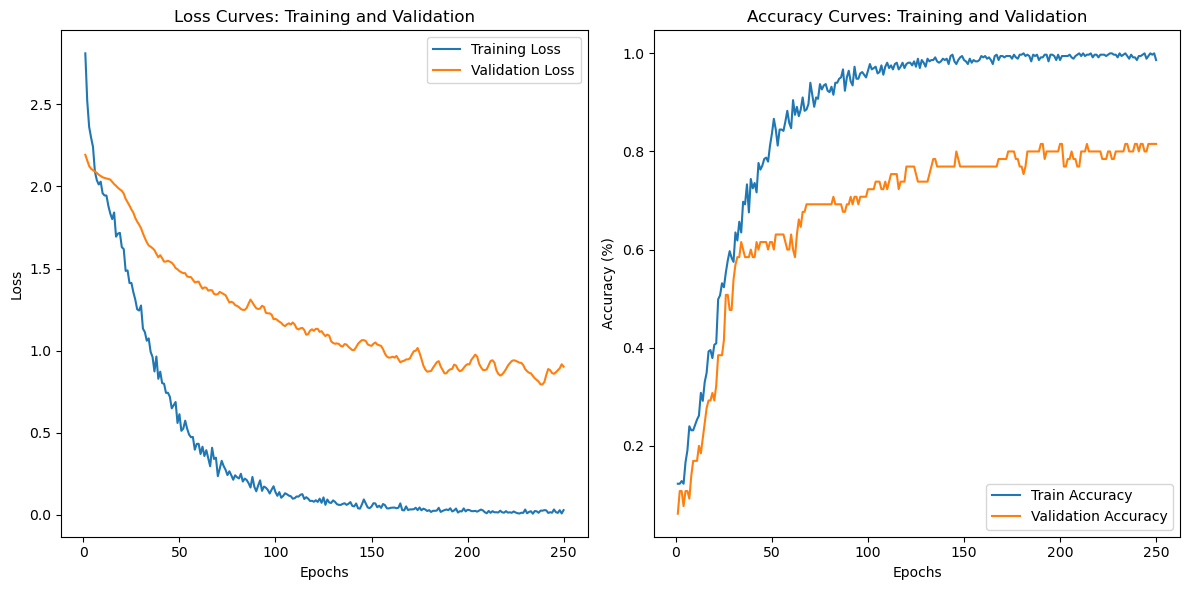

Test set Accuracy: 0.4167
Recall: 0.4167
F1 Score: 0.4087


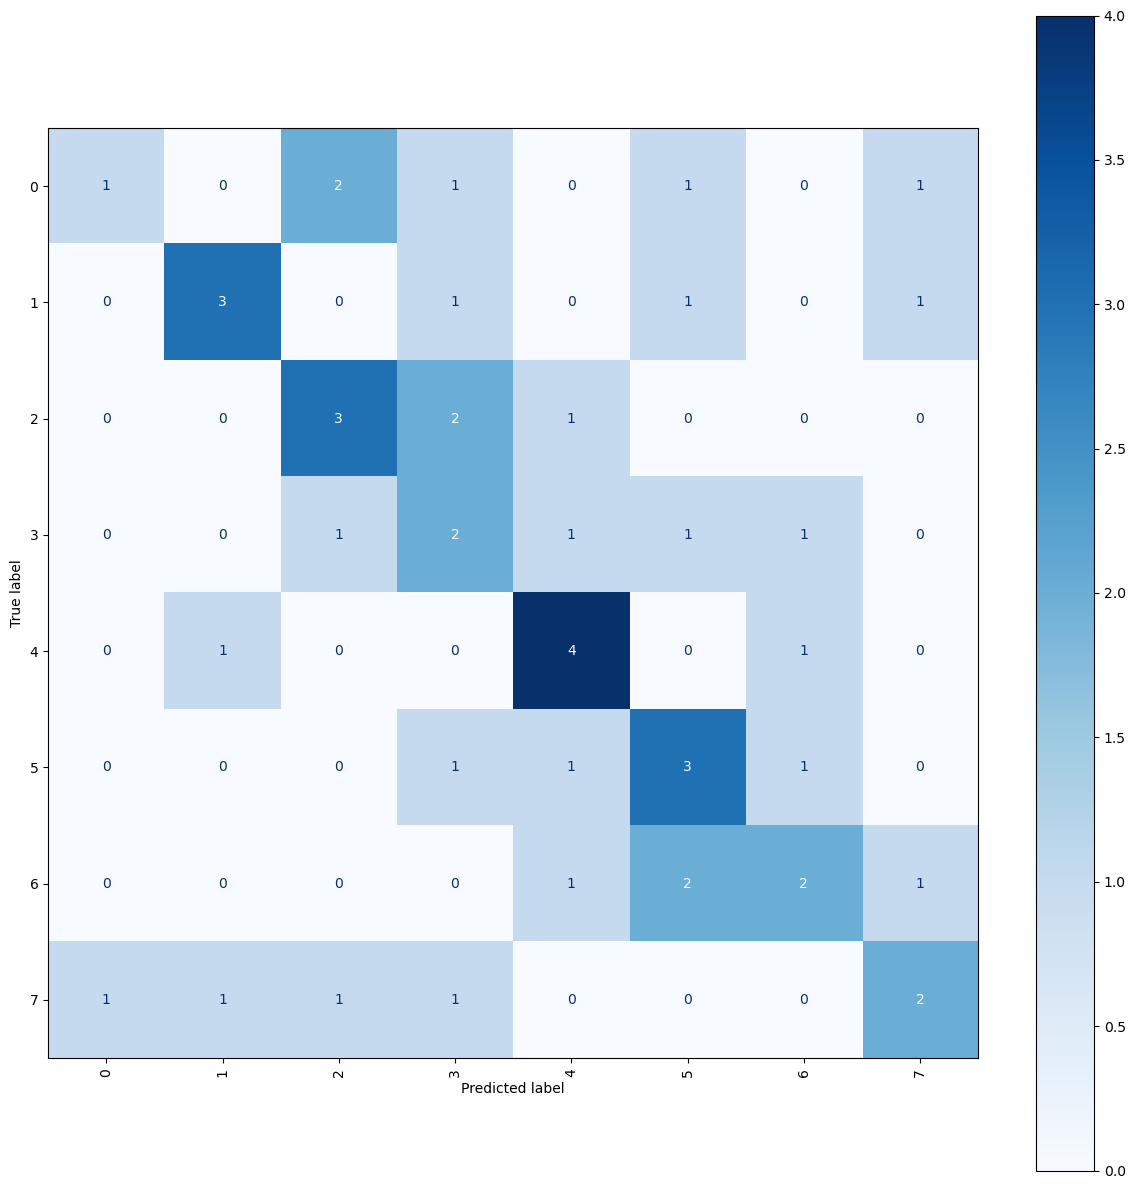

Usuário 9 Finalizado: Acurácia=0.4167, Recall=0.4167, F1=0.4087
--------------------------------------------------
Processando Usuário 10
All data shape before filtering: (432, 9, 250)
All data shape after filtering: (432, 5, 9, 250)
All data shape before filtering: (48, 9, 250)
All data shape after filtering: (48, 5, 9, 250)
X_train: torch.Size([432, 5, 9, 250])
X_test: torch.Size([48, 5, 9, 250])
Y_train: torch.Size([432])
Y_test: torch.Size([48])


  0%|          | 0/250 [00:00<?, ?it/s]

Epoch 1/250: Train Loss: 3.0348, Train Accuracy: 0.0926, Val Loss: 2.1667, Val Accuracy: 0.0615
Epoch 2/250: Train Loss: 2.6024, Train Accuracy: 0.1444, Val Loss: 2.1309, Val Accuracy: 0.1077
Epoch 3/250: Train Loss: 2.3735, Train Accuracy: 0.1689, Val Loss: 2.1121, Val Accuracy: 0.1077
Epoch 4/250: Train Loss: 2.3525, Train Accuracy: 0.2098, Val Loss: 2.0997, Val Accuracy: 0.0923
Epoch 5/250: Train Loss: 2.2521, Train Accuracy: 0.1798, Val Loss: 2.0897, Val Accuracy: 0.1077
Epoch 6/250: Train Loss: 2.2202, Train Accuracy: 0.1907, Val Loss: 2.0891, Val Accuracy: 0.1385
Epoch 7/250: Train Loss: 2.1036, Train Accuracy: 0.2262, Val Loss: 2.0874, Val Accuracy: 0.1385
Epoch 8/250: Train Loss: 2.0656, Train Accuracy: 0.2180, Val Loss: 2.0872, Val Accuracy: 0.1692
Epoch 9/250: Train Loss: 2.0545, Train Accuracy: 0.2153, Val Loss: 2.0792, Val Accuracy: 0.2154
Epoch 10/250: Train Loss: 2.0073, Train Accuracy: 0.2207, Val Loss: 2.0741, Val Accuracy: 0.1538
Epoch 11/250: Train Loss: 1.9062, Train

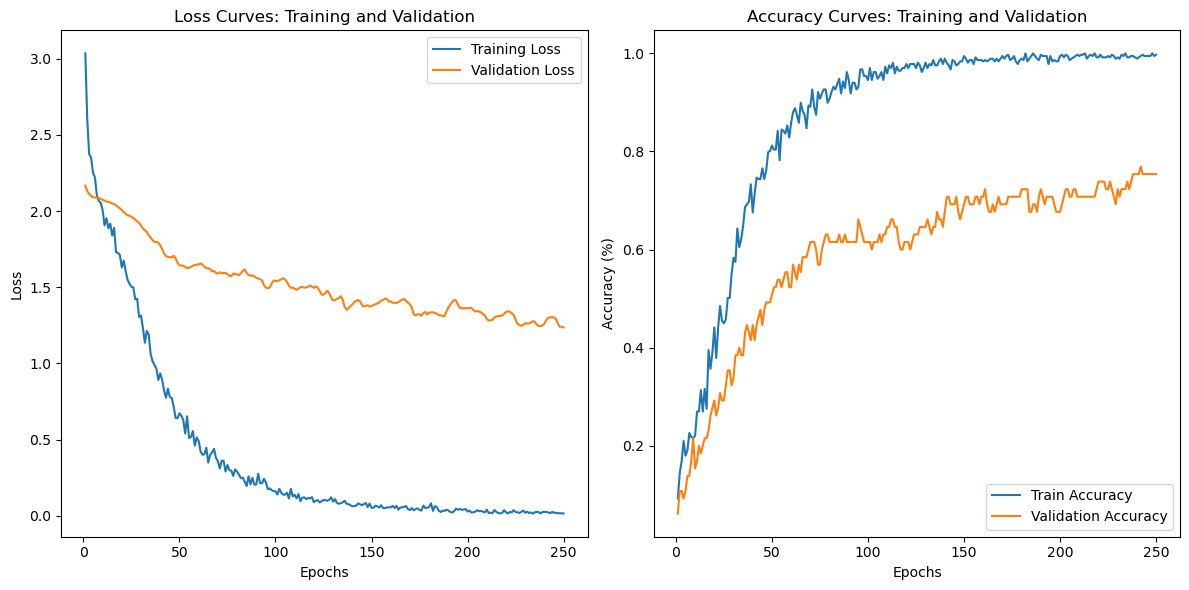

Test set Accuracy: 0.6458
Recall: 0.6458
F1 Score: 0.6141


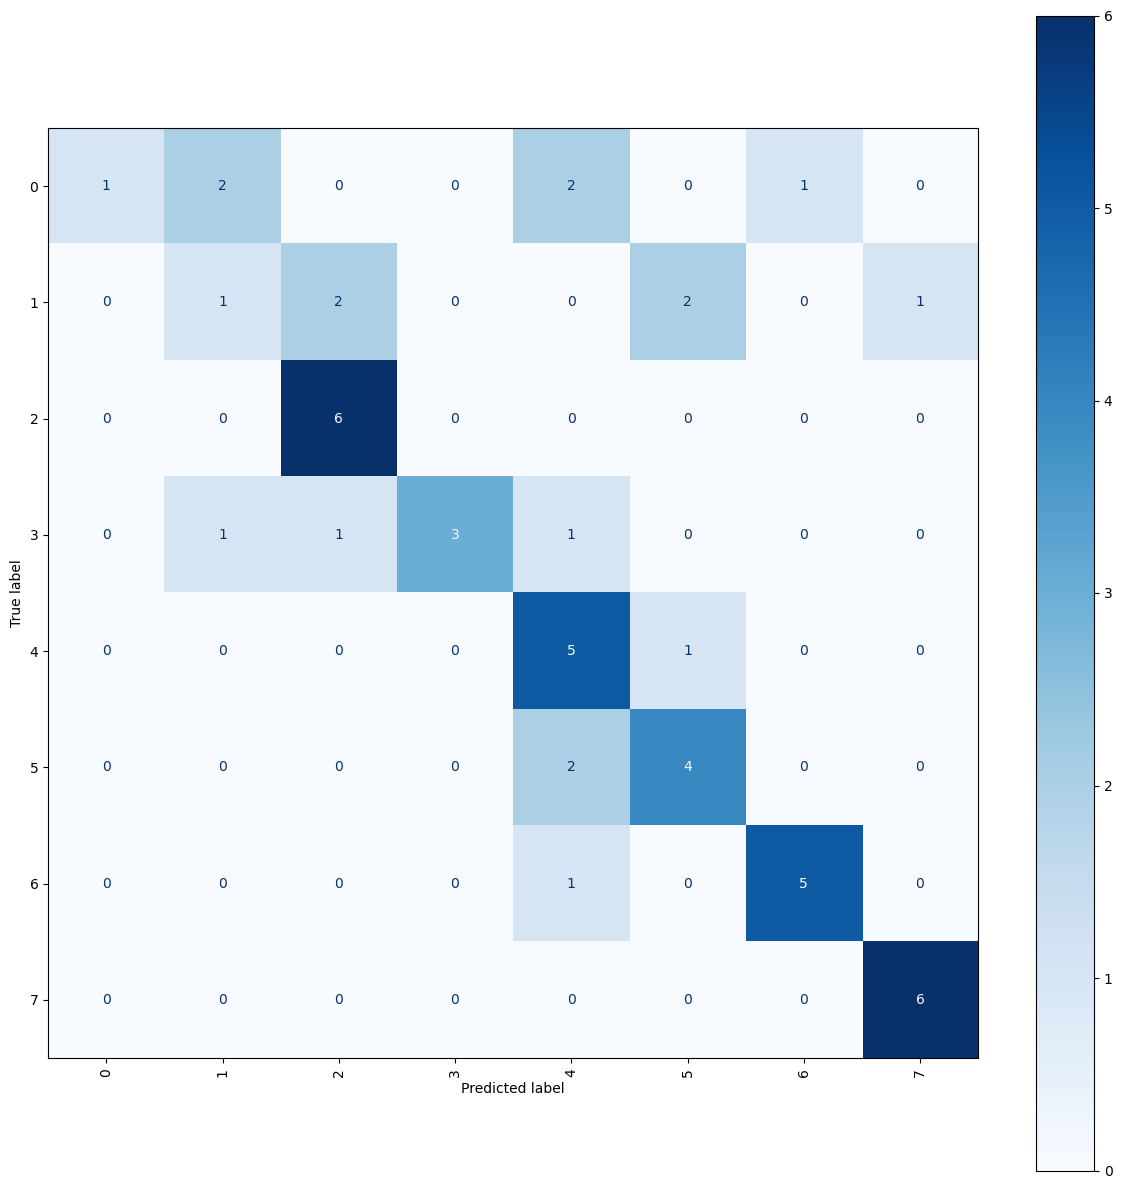

Usuário 10 Finalizado: Acurácia=0.6458, Recall=0.6458, F1=0.6141
--------------------------------------------------


In [ ]:
seed = 42
torch.cuda.manual_seed(seed)
torch.manual_seed(seed)

metricas_usuarios = []
exp_dir.mkdir(parents=True, exist_ok=True)

for user in range(1, len(all_data) + 1):
    print(f"Processando Usuário {user}")
    n_freqs_sel = len(indices)
    metricas_crossval = []
    users_train = [u for u in range(1, len(all_data) + 1) if u != user]
    user_test = user

    x_train = []
    labels_train = []
    x_test = []
    labels_test = []

    # Train users
    for u in users_train:
        data = all_data[u - 1]
        for session in range(data.shape[3]):
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], session]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_train.append(eeg_trial)
                labels_train.extend([frequencias[freq]])
    x_train = np.array(x_train)
    x_train = filter_signals_subbands(x_train, subban_no=1, sampling_rate=250)

    # Test user
    data = all_data[user_test - 1]
    for session in range(data.shape[3]):
        for freq in range(len(indices)):
            eeg_trial = data[occipital_electrodes, :, indices[freq], session]
            eeg_trial = eeg_trial[:, :tamanho_da_janela]
            x_test.append(eeg_trial)
            labels_test.extend([frequencias[freq]])
    x_test = np.array(x_test)
    x_test = filter_signals_subbands(x_test, subban_no=5, sampling_rate=250)

    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    labels_train = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_train])
    labels_test = torch.tensor([mapeamento[rotulo.item()] for rotulo in labels_test])

    X_train = torch.from_numpy(x_train.copy()).float().to(device)
    X_test = torch.from_numpy(x_test.copy()).float().to(device)
    Y_train = labels_train.to(torch.long).to(device)
    Y_test = labels_test.to(torch.long).to(device)
    print("X_train:", X_train.shape)
    print("X_test:", X_test.shape)
    print("Y_train:", Y_train.shape)
    print("Y_test:", Y_test.shape)

    model = CUSTOM(
        num_classes=len(frequencias_desejadas),
        channels=9,
        samples=tamanho_da_janela,
        subbands=3,
    ).to(device)

    dataset = TensorDataset(X_train, Y_train)
    train_size = int(0.85 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(
        dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader = DataLoader(
        TensorDataset(X_test, Y_test), batch_size=10, shuffle=False
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)

    best_model = train(
        model,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs,
        device=device,
        save_path=exp_dir.joinpath(f"best_model_user_{user}.pth"),
    )
    accuracy, recall, f1, cm = evaluate(best_model, test_loader)
    metricas_crossval.append(
        {
            "usuario": user,
            "acuracia": accuracy,
            "recall": recall,
            "f1-score": f1,
            "confusion_matrix": cm,
        }
    )
    print(
        f"Usuário {user} Finalizado: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
    )
    metricas_usuarios.extend(metricas_crossval)
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(exp_dir.joinpath(f"metricas.csv"), index=False)
    print("-" * 50)

# Leave-One-Session-Out Cross Validation (General + Fine-tune)

In [ ]:
frequencias_e_fases = scipy.io.loadmat(
    "C:/Users/machi/Documents/Mestrado/repos/data/benchmark/Freq_Phase.mat"
)
frequencias = frequencias_e_fases["freqs"]
frequencias = np.round(frequencias, 2).ravel()
fases = frequencias_e_fases["phases"]


# Parâmetros de pré-processamento
sample_rate = 250
delay = 160  # 160 amostras, 0,5s (sem estimulação) + 0,14s (latencia para começo da evocação)

# Parâmetros de janelas e sessões
tamanho_da_janela = 1
tamanho_da_janela = int(np.ceil(tamanho_da_janela * sample_rate))

# Eletrodos e frequências de interesse
occipital_electrodes = np.array([47, 53, 54, 55, 56, 57, 60, 61, 62])
frequencias_desejadas = frequencias[:]
indices = [np.where(frequencias == freq)[0][0] for freq in frequencias_desejadas]

epochs_general = 2
epochs_fine_tune = 5


exp_dir = Path("dnn_leave-one-session-out-10_freqs_1s")

In [ ]:
all_data = load_data_from_users(
    users=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10], visual_delay=delay
)

In [ ]:
exp_dir.mkdir(parents=True, exist_ok=True)
general_models_dir = exp_dir.joinpath("general_models")
general_models_dir.mkdir(parents=True, exist_ok=True)
fine_tuned_models_dir = exp_dir.joinpath("fine_tuned_models")
fine_tuned_models_dir.mkdir(parents=True, exist_ok=True)
metricas_usuarios = []
num_sessions = 6
num_users = len(all_data)

for sessao_teste in range(num_sessions):
    print(f"Sessão de teste: {sessao_teste}")
    x_train_general = []
    y_train_general = []

    for user in range(num_users):
        data = all_data[user]
        for sessao in range(num_sessions):
            if sessao == sessao_teste:
                continue
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], sessao]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_train_general.append(eeg_trial)
                y_train_general.extend([frequencias[freq]])
                # eeg_trial_janelas, numero_janelas = separar_em_janelas(
                #     eeg_trial.T, tamanho_da_janela
                # )
                # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
                # x_train_general.append(eeg_trial_janelas_array)
                # y_train_general.extend([frequencias[freq]] * numero_janelas)
    x_train_general = np.array(x_train_general)
    mapeamento = {rotulo: i for i, rotulo in enumerate(sorted(frequencias_desejadas))}
    y_train_general_tensor = torch.tensor(
        [mapeamento[rotulo.item()] for rotulo in y_train_general]
    )
    # DNN expects [batch, subbands, channels, time]
    x_train_general = filter_signals_subbands(
        x_train_general, subban_no=3, sampling_rate=250
    )
    X_train_general = torch.from_numpy(x_train_general.copy()).float().to(device)
    Y_train_general = y_train_general_tensor.to(torch.long).to(device)
    model_general = SSVEPDNN(
        num_classes=len(frequencias_desejadas),
        channels=9,
        samples=tamanho_da_janela,
        subbands=3,
    ).to(device)
    dataset_general = TensorDataset(X_train_general, Y_train_general)
    train_size = int(0.85 * len(dataset_general))
    val_size = len(dataset_general) - train_size
    train_dataset, val_dataset = random_split(
        dataset_general,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(seed),
    )
    train_loader = DataLoader(dataset_general, batch_size=64, shuffle=True)
    val_loader = DataLoader(dataset_general, batch_size=16, shuffle=False)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model_general.parameters(), lr=0.0001)
    print("Treinando modelo geral...")
    best_model_general = train(
        model_general,
        train_loader,
        val_loader,
        criterion,
        optimizer,
        num_epochs=epochs_general,
        device=device,
        save_path=general_models_dir.joinpath(
            f"best_general_model_session_{sessao_teste}.pth"
        ),
    )

    # Fine-tuning para cada usuário
    for user in range(num_users):
        print(f"Usuário {user+1} - Fine-tuning e validação na sessão {sessao_teste}")
        data = all_data[user]
        x_finetune = []
        y_finetune = []
        for sessao in range(num_sessions):
            if sessao == sessao_teste:
                continue
            for freq in range(len(indices)):
                eeg_trial = data[occipital_electrodes, :, indices[freq], sessao]
                eeg_trial = eeg_trial[:, :tamanho_da_janela]
                x_finetune.append(eeg_trial)
                y_finetune.extend([frequencias[freq]])
                # eeg_trial_janelas, numero_janelas = separar_em_janelas(
                #     eeg_trial.T, tamanho_da_janela
                # )
                # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
                # x_finetune.append(eeg_trial_janelas_array)
                # y_finetune.extend([frequencias[freq]] * numero_janelas)
        x_finetune = np.array(x_finetune)
        x_finetune = filter_signals_subbands(x_finetune, subban_no=3, sampling_rate=250)
        X_finetune = torch.from_numpy(x_finetune.copy()).float().to(device)
        y_finetune_tensor = torch.tensor(
            [mapeamento[rotulo.item()] for rotulo in y_finetune]
        )
        Y_finetune = y_finetune_tensor.to(torch.long).to(device)
        x_test = []
        y_test = []
        for freq in range(len(indices)):
            eeg_trial = data[occipital_electrodes, :, indices[freq], sessao_teste]
            eeg_trial = eeg_trial[:, :tamanho_da_janela]
            x_test.append(eeg_trial)
            y_test.extend([frequencias[freq]])
            # eeg_trial_janelas, numero_janelas = separar_em_janelas(
            #     eeg_trial.T, tamanho_da_janela
            # )
            # eeg_trial_janelas_array = np.stack(eeg_trial_janelas).transpose(0, 2, 1)
            # x_test.append(eeg_trial_janelas_array)
            # y_test.extend([frequencias[freq]] * numero_janelas)

        x_test = np.array(x_test)
        x_test = filter_signals_subbands(x_test, subban_no=3, sampling_rate=250)
        X_test = torch.from_numpy(x_test.copy()).float().to(device)
        y_test_tensor = torch.tensor([mapeamento[rotulo.item()] for rotulo in y_test])
        Y_test = y_test_tensor.to(torch.long).to(device)
        model_finetune = SSVEPDNN(
            num_classes=len(frequencias_desejadas),
            channels=9,
            samples=tamanho_da_janela,
            subbands=3,
        ).to(device)
        model_finetune.load_state_dict(best_model_general.state_dict())
        dataset_finetune = TensorDataset(X_finetune, Y_finetune)
        train_size = int(0.85 * len(dataset_finetune))
        val_size = len(dataset_finetune) - train_size
        train_dataset, val_dataset = random_split(
            dataset_finetune,
            [train_size, val_size],
            generator=torch.Generator().manual_seed(seed),
        )
        train_loader = DataLoader(dataset_finetune, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
        test_loader = DataLoader(
            TensorDataset(X_test, Y_test), batch_size=10, shuffle=False
        )
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model_finetune.parameters(), lr=0.00005)
        print("Fine-tuning modelo para o usuário...")
        best_model_finetune = train(
            model_finetune,
            train_loader,
            test_loader,
            criterion,
            optimizer,
            num_epochs=epochs_fine_tune,
            device=device,
        )
        accuracy, recall, f1, cm = evaluate(best_model_finetune, test_loader)
        metricas_usuarios.append(
            {
                "usuario": user + 1,
                "sessao_teste": sessao_teste,
                "acuracia": accuracy,
                "recall": recall,
                "f1-score": f1,
                "confusion_matrix": cm,
            }
        )
        print(
            f"Usuário {user+1} - Sessão {sessao_teste} Finalizada: Acurácia={accuracy:.4f}, Recall={recall:.4f}, F1={f1:.4f}"
        )
    print("-" * 50)
    df_metricas = pd.DataFrame(metricas_usuarios)
    df_metricas.to_csv(
        exp_dir.joinpath(f"{exp_dir}_metricas_leave_one_session_out_finetune.csv"),
        index=False,
    )